# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error
from copy import deepcopy as dc

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback, accuracy
from baseline_model.LSTM import LSTMRegression, train_model
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [2]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

In [3]:
MODEL = 'lstm'
FEATURES = ['Trend', 'Log Close', 'Volume', 'Daily Returns Percent']
CLASSES = ['down', 'up']

LEARNING_RATE = 0.001 if MODEL == 'lstm' else 0.0001
FIRST_SPLIT = 0.8
SECOND_SPLIT = 0.5 

SEQ_LEN = 14
BATCH_SIZE = 32
HIDDEN_SIZE = 6
NUM_LAYERS = 1

NUM_EPOCHS = 1000

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [5]:
aapl = load_complete_time_series(REAL_DATA_FOLDER / "AAPL_complete.csv")

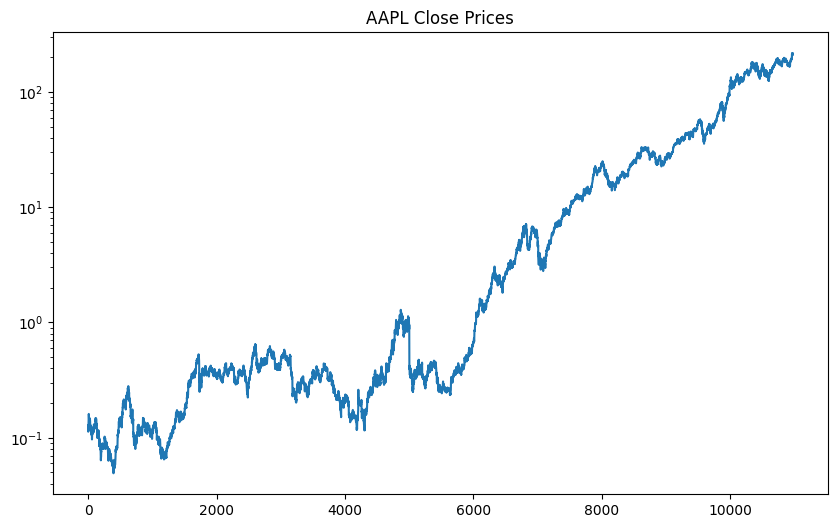

In [6]:
# plot log of close prices
plt.figure(figsize=(10, 6))
plt.plot(aapl['Close'])
plt.yscale('log')
plt.title('AAPL Close Prices')
plt.show()

In [7]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
aapl['Daily Returns Percent'] = aapl['Close'].pct_change()

In [8]:
# get log values
aapl['Log Close'] = np.log(aapl['Close'])

In [9]:
# set trend to 1 if daily return > 1, else -1
aapl['Trend'] = aapl['Daily Returns Percent'].apply(lambda x: 1 if x > 0 else 0)

In [10]:
aapl = aapl.dropna()
aapl = aapl[FEATURES]

In [11]:
aapl.head()

,Trend,Log Close,Volume,Daily Returns Percent
1,0,-2.106591,175884800,-0.052171
2,0,-2.182822,105728000,-0.073398
3,1,-2.158372,86441600,0.024751
4,1,-2.129792,73449600,0.028992
5,1,-2.070553,48630400,0.061029


In [12]:
aapl_np = aapl.to_numpy()

In [13]:
aapl_train, aapl_test = train_test_split(aapl_np, FIRST_SPLIT)
aapl_test, aapl_val = train_test_split(aapl_test, SECOND_SPLIT)

In [14]:
aapl_test_dummy = split_data_into_sequences(aapl_test, SEQ_LEN)

Shape of the data after splitting into sequences: (1085, 14, 4)


In [15]:
scaler = Scaler(aapl_train)

In [16]:
aapl_train_scaled = scaler.scale_data(aapl_train)
aapl_test_scaled = scaler.scale_data(aapl_test)
aapl_val_scaled = scaler.scale_data(aapl_val)

In [17]:
aapl_train_seq_scaled = split_data_into_sequences(aapl_train_scaled, SEQ_LEN)
aapl_test_seq_scaled = split_data_into_sequences(aapl_test_scaled, SEQ_LEN)
aapl_val_seq_scaled = split_data_into_sequences(aapl_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (8768, 14, 4)
Shape of the data after splitting into sequences: (1085, 14, 4)
Shape of the data after splitting into sequences: (1085, 14, 4)


In [18]:
aapl_train_seq_scaled[0]

array([[0.        , 0.1391822 , 0.02369891, 0.09644285],
       [0.        , 0.12748639, 0.01424591, 0.04655351],
       [1.        , 0.13123759, 0.01164724, 0.27722803],
       [1.        , 0.13562251, 0.00989668, 0.28719656],
       [1.        , 0.1447113 , 0.00655251, 0.36249006],
       [1.        , 0.15200243, 0.00503436, 0.33344264],
       [1.        , 0.15834398, 0.00632615, 0.31823562],
       [1.        , 0.16621319, 0.006468  , 0.3427465 ],
       [1.        , 0.17975972, 0.00748816, 0.4360062 ],
       [1.        , 0.18190544, 0.0125527 , 0.25215714],
       [0.        , 0.17813051, 0.00928097, 0.16193644],
       [0.        , 0.17369942, 0.00481705, 0.15215024],
       [1.        , 0.17537611, 0.0029186 , 0.24488233],
       [0.        , 0.1720042 , 0.00481403, 0.16796795]])

In [19]:
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(aapl_train_seq_scaled, aapl_test_seq_scaled, aapl_val_seq_scaled)

In [20]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [21]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [22]:
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()
criterion_binary_logits = nn.BCEWithLogitsLoss()
criterion_binary = nn.BCELoss()

In [23]:
losses = []
accs = []
validation_loss_accumulation_callback = ValidationLossAccumulationCallback(losses)

In [24]:
if MODEL == 'lstm':

    model = LSTMRegression(
        device=device,
        input_size=X_train.shape[2], # number of features
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    losses, accs, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=test_loader,
                        criterion=criterion_binary_logits,
                        optimizer=optimizer,
                        device=device)
    
elif MODEL == 'xgb':

    model = XGBClassifier(
        objective='multi:softprob',
        num_class=2,      
        max_depth=10,       
        learning_rate=0.001,
        n_estimators=1000
    )
    
    # model = XGBRegressor(
    #     n_estimators=10000,
    #     max_depth=10,
    #     learning_rate=0.001,
    #     subsample=0.8,
    #     objective='reg:squarederror',
    #     early_stopping_rounds=10, 
    #     eval_metric=mean_absolute_error,
    #     callbacks=[validation_loss_accumulation_callback], 
    #     verbosity=2,
    #     random_state=69,
    #     device=device
    # )
    model.fit(
        X_train.reshape((X_train.shape[0], -1)), 
        y_train,
        eval_set=[(X_val.reshape((X_val.shape[0], -1)), y_val)]
    )

Epoch: 1
Validation Loss: 0.6913435424075407
Validation Accuracy: 53.65428498985801
**************************************************
Epoch: 2
Validation Loss: 0.6911393579314736
Validation Accuracy: 53.65428498985801
**************************************************
Epoch: 3
Validation Loss: 0.6909288220545825
Validation Accuracy: 53.65428498985801
**************************************************
Epoch: 4
Validation Loss: 0.6907623410224915
Validation Accuracy: 53.65428498985801
**************************************************
Epoch: 5
Validation Loss: 0.6906476686982548
Validation Accuracy: 53.65428498985801
**************************************************
Epoch: 6
Validation Loss: 0.6905764148515814
Validation Accuracy: 53.65428498985801
**************************************************
Epoch: 7
Validation Loss: 0.6905349387842066
Validation Accuracy: 53.65428498985801
**************************************************
Epoch: 8
Validation Loss: 0.690511719268911
Validation 

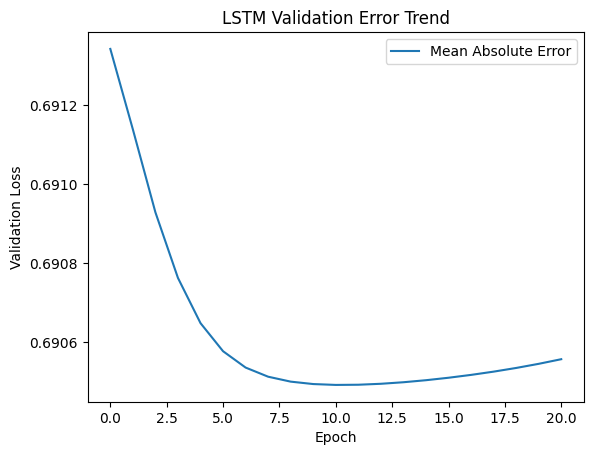

In [25]:
# plot validation loss
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Validation Error Trend')
plt.plot(losses, label="Mean Absolute Error")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

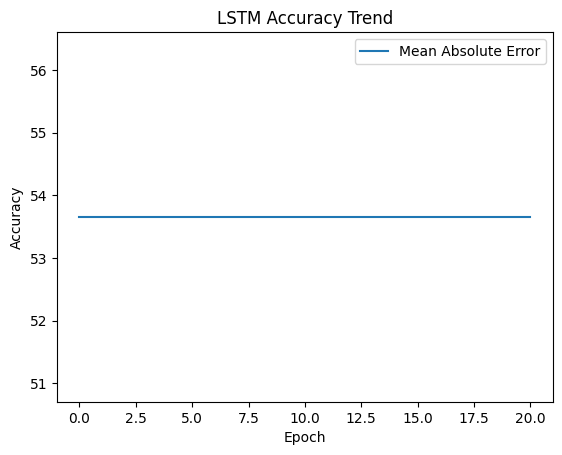

In [26]:
# plot validation loss
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Accuracy Trend')
plt.plot(accs, label="Mean Absolute Error")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Evaluation

In [27]:
if MODEL == 'lstm':

    with torch.inference_mode(): 
        test_logits = model(X_test.to(device)) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes
        train_logits = model(X_train.to(device))
        train_probs = torch.sigmoid(train_logits)
        train_preds = torch.round(train_probs)

elif MODEL == 'xgb':
        
    test_logits = model.predict(X_test.reshape((X_test.shape[0], -1)))
    train_logits = model.predict(X_train.reshape((X_train.shape[0], -1)))

In [28]:
test_logits = scaler.inverse_scale_data(test_logits, feature_type='price')
train_logits = scaler.inverse_scale_data(train_logits, feature_type='price')
y_test = scaler.inverse_scale_data(y_test.cpu().numpy(), feature_type='price')
y_train = scaler.inverse_scale_data(y_train.cpu().numpy(), feature_type='price')

ValueError: Data is not a numpy array.

In [ ]:
# mean absolute error of only zeros
loss = criterion_absolute(torch.zeros_like(torch.tensor(y_test)), torch.tensor(y_test)).item()
loss

177.75717180631057

In [ ]:
test_range = (0, 50)
train_range = (0, len(y_train))

In [ ]:
# mean absolute error of test data predictions
loss = criterion_absolute(torch.tensor(test_logits), torch.tensor(y_test)).item()
loss

# plot test data
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Test Data Predictions {test_range[1]-test_range[0]} Days')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(np.roll(test_logits[test_range[0]: test_range[1]], 0), label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.legend()
plt.show()

NameError: name 'test_pred' is not defined

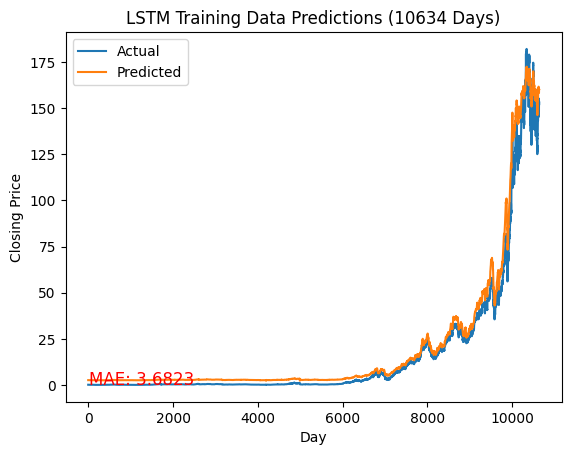

In [ ]:
# mean absolute error of training data predictions
loss = criterion_absolute(torch.tensor(train_logits), torch.tensor(y_train)).item()
loss

# plot train data
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Training Data Predictions ({train_range[1]-train_range[0]} Days)')
plt.plot(y_train[train_range[0]: train_range[1]], label="Actual")
plt.plot(train_logits[train_range[0]: train_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_train[train_range[0]: train_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

In [ ]:
y_train[7000]

4.059286060611576

### dummy testing

In [ ]:
dummy = MeanRegressor()

In [ ]:
dummy_preds = dummy.make_predictions(aapl_test_dummy, returns=True if 'Daily Returns' in FEATURES else False)

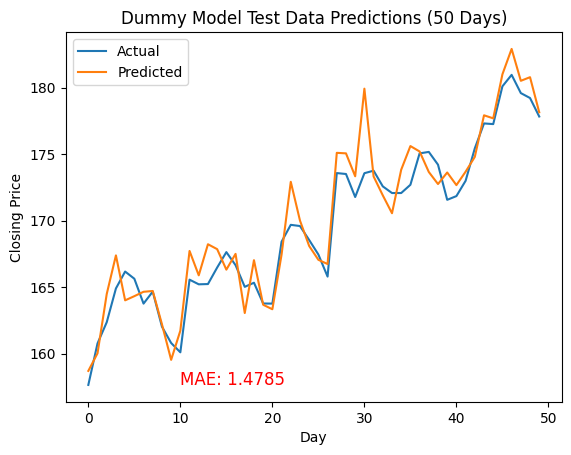

In [ ]:
loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
loss

# plot train data
plt.title(f'Dummy Model Test Data Predictions ({test_range[1]-test_range[0]} Days)')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(dummy_preds[test_range[0]: test_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

## MAE and MSE Loss experiments

In [ ]:
# real = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# A = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 12])
# B = np.array([1, 2.1, 3.1, 4.1, 5.1, 6, 7, 8, 9, 10])

# # scale
# scaler = MinMaxScaler(feature_range=(0, 1))
# real_scaled = scaler.fit_transform(real.reshape(-1, 1))
# A_scaled = scaler.fit_transform(A.reshape(-1, 1))
# B_scaled = scaler.fit_transform(B.reshape(-1, 1))

# loss_MSE = torch.nn.MSELoss()
# loss_MAE = torch.nn.L1Loss()

# MSE_A = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(A_scaled, dtype=torch.float32))
# MAE_A = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(A, dtype=torch.float32))
# MSE_B = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(B_scaled, dtype=torch.float32))
# MAE_B = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(B, dtype=torch.float32))

# print(f'MSE_A: {MSE_A}\n')
# print(f'MAE_A: {MAE_A}\n')
# print(f'MSE_B: {MSE_B}\n')
# print(f'MAE_B: {MAE_B}\n')